In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import sklearn.metrics as smt
import seaborn as sns

print('done')

done


In [9]:
df = pd.read_csv('data/Dataset.csv')
df.head(5)

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan


In [10]:
df.describe()

,id,label
count,2562,2562
unique,2562,31
top,Robert Downey Jr_87.jpg,Brad Pitt
freq,1,120


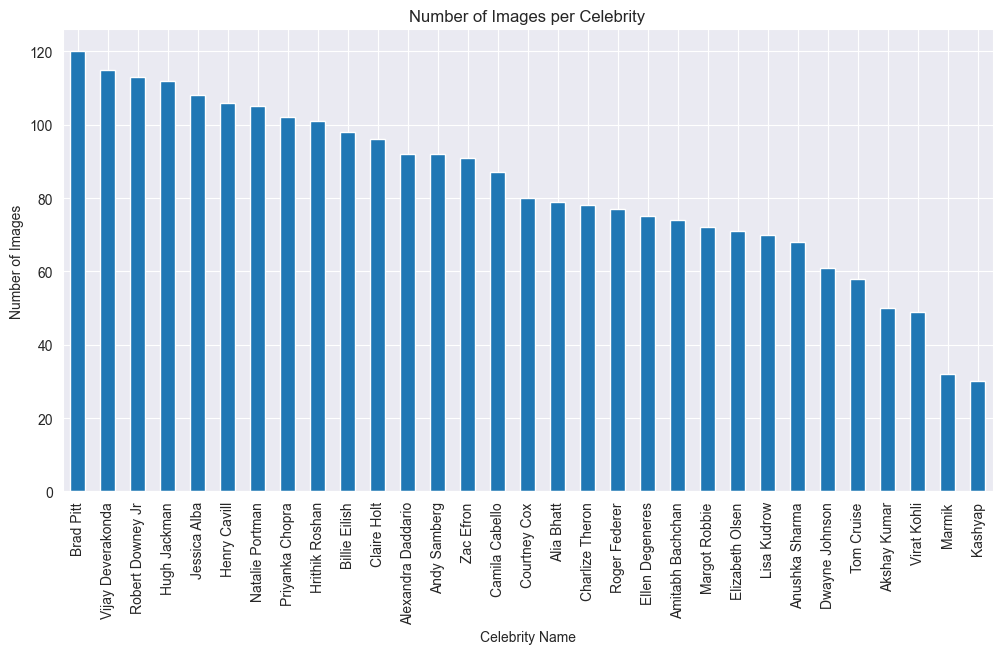

In [11]:
# Plot distribution of images per celebrity
df['label'].value_counts().plot(kind='bar', figsize=(12,6))
plt.title('Number of Images per Celebrity')
plt.xlabel('Celebrity Name')
plt.ylabel('Number of Images')
plt.show()

In [12]:

# Путь к папке с изображениями
faces_dir = "data/Faces/Faces"

# Проверка наличия файлов
missing_files = []
for file_name in df['id']:
    file_path = os.path.join(faces_dir, file_name)
    if not os.path.exists(file_path):
        missing_files.append(file_name)

print(f"Пропущенные файлы: {missing_files}")

Пропущенные файлы: []


In [13]:
from PIL import Image
import numpy as np

def load_images(df, image_dir):
    images = []
    labels = []

    for _, row in df.iterrows():
        file_name = row['id']
        label = row['label']
        file_path = os.path.join(image_dir, file_name)

        # Загрузка изображения
        try:
            img = Image.open(file_path)
            img = img.convert('RGB')  # Убедитесь, что изображение в RGB
            images.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Ошибка при загрузке файла {file_path}: {e}")

    return np.array(images), np.array(labels)

# Пример использования
images, labels = load_images(df, faces_dir)
print(f"Загружено изображений: {len(images)}")

Загружено изображений: 2562


In [14]:
def resize_images(images, target_size=(128, 128)):
    resized_images = [np.array(Image.fromarray(img).resize(target_size)) for img in images]
    return np.array(resized_images)

# Пример использования
resized_images = resize_images(images)
print(f"Размер изображений: {resized_images.shape}")

Размер изображений: (2562, 128, 128, 3)


In [15]:
def normalize_images(images):
    return images / 255.0

# Пример использования
normalized_images = normalize_images(resized_images)

In [16]:
from sklearn.model_selection import train_test_split

# Разделение данных
train_images, test_images, train_labels, test_labels = train_test_split(
    normalized_images, labels, test_size=0.2, random_state=42
)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {len(train_images)}")
print(f"Валидационная выборка: {len(val_images)}")
print(f"Тестовая выборка: {len(test_images)}")

Обучающая выборка: 1639
Валидационная выборка: 410
Тестовая выборка: 513


In [17]:
from sklearn.preprocessing import LabelEncoder

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование меток в числовые значения
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [47]:
import joblib

# Сохранение LabelEncoder
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [18]:
print("Первые 5 меток:", train_labels[:5])
print("Закодированные метки:", train_labels_encoded[:5])

Первые 5 меток: ['Andy Samberg' 'Henry Cavill' 'Lisa Kudrow' 'Andy Samberg' 'Henry Cavill']
Закодированные метки: [ 4 15 20  4 15]


In [19]:
import numpy as np

data_dir = 'data/'
# Сохранение данных в NumPy
np.save(data_dir + "train_images.npy", train_images)
np.save(data_dir + "train_labels.npy", train_labels_encoded)
np.save(data_dir + "val_images.npy", val_images)
np.save(data_dir + "val_labels.npy", val_labels_encoded)
np.save(data_dir + "test_images.npy", test_images)
np.save(data_dir + "test_labels.npy", test_labels_encoded)

In [34]:
# Загрузка данных
import numpy as np

data_dir = 'data/'

train_images = np.load(data_dir + "train_images.npy")
train_labels = np.load(data_dir + "train_labels.npy")
val_images = np.load(data_dir + "val_images.npy")
val_labels = np.load(data_dir + "val_labels.npy")
test_images = np.load(data_dir + "test_images.npy")
test_labels = np.load(data_dir + "test_labels.npy")

print(f"Обучающая выборка: {len(train_images)}")
print(f"Валидационная выборка: {len(val_images)}")
print(f"Тестовая выборка: {len(test_images)}")

Обучающая выборка: 1639
Валидационная выборка: 410
Тестовая выборка: 513


In [35]:
print("Первые 5 меток:", train_labels[:10])

Первые 5 меток: [ 4 15 20  4 15 10 25 19 26 11]


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  # num_classes — количество людей
    ])
    return model

# Пример использования
input_shape = (128, 128, 3)  # Размер изображений
num_classes = len(set(train_labels))  # Количество уникальных меток
print(f"Количество классов: {num_classes}")
model = create_model(input_shape, num_classes)
model.summary()

Количество классов: 31


X:\projects\neuro1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,639 (12.62 MB)

 Trainable params: 3,308,639 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Для целочисленных меток
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32
)

# Сохранение модели
model.save("facedetectmo.keras")

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.0319 - loss: 3.4660 - val_accuracy: 0.0561 - val_loss: 3.3931
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.0767 - loss: 3.3105 - val_accuracy: 0.1098 - val_loss: 3.0447
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.1849 - loss: 2.8925 - val_accuracy: 0.2244 - val_loss: 2.7056
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.2659 - loss: 2.5401 - val_accuracy: 0.3171 - val_loss: 2.3598
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.3272 - loss: 2.2761 - val_accuracy: 0.3829 - val_loss: 2.2392
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.4140 - loss: 1.9867 - val_accuracy: 0.4000 - val_loss: 2.0365
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.4316 - loss: 1.7873 - val_accuracy: 0.4537 - val_loss: 1.8793
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5213 - loss: 1.5169 - val_accuracy: 0.

In [41]:
model = tf.keras.models.load_model("facedetectmo.keras")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


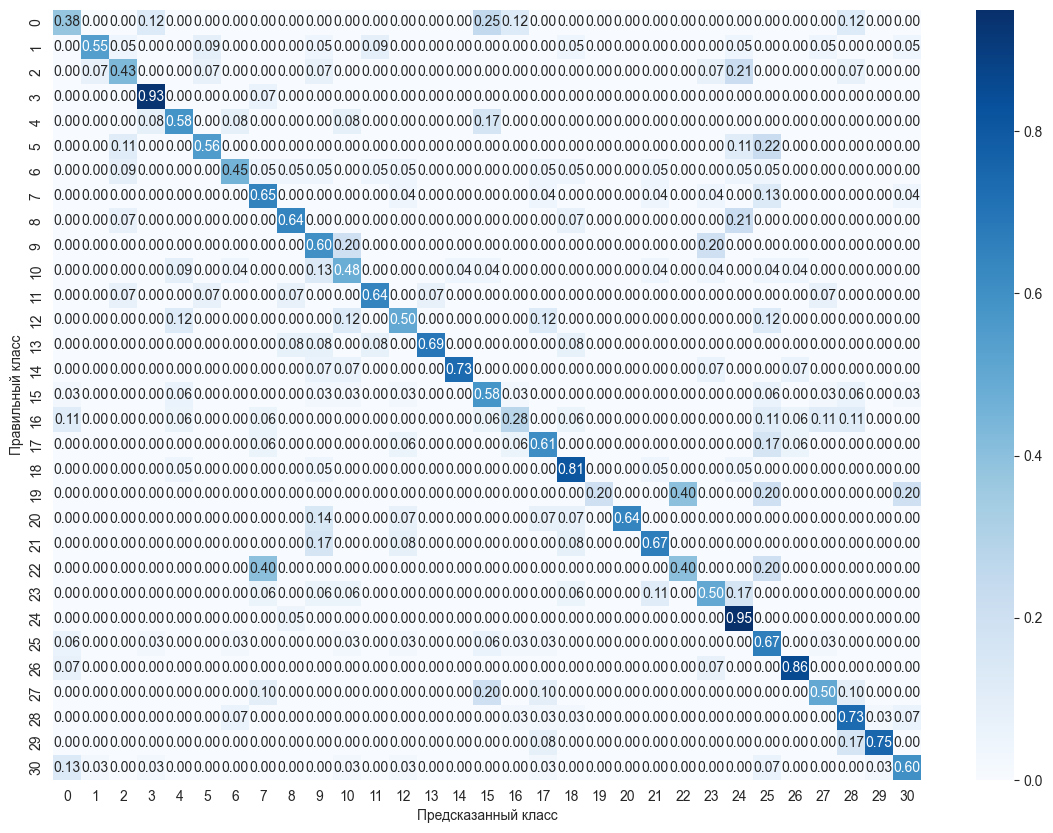

In [46]:
# матрица ошибок
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

cm = tf.math.confusion_matrix(y_true, y_pred).numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Правильный класс')
plt.show()

In [42]:


test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Точность на тестовой выборке: {test_accuracy:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5967 - loss: 1.7327
Точность на тестовой выборке: 0.62
